predicting a sequence of future prices (`n_steps_out`) instead of just one day.

Benefits of This Approach
Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.

I will using wasserstein GAN 

In [3]:
# !pip install -r requirements.txt -q
# !pip install ipython-autotime -q
# !sudo apt install graphviz -y -qq
# !pip install tensorflow-addons -q

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM, Conv1D, ReLU, LeakyReLU, LayerNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
tensorflow version: 2.15.0
Num GPUs Available:  1


True

time: 11 ms (started: 2024-11-25 14:51:21 +00:00)


In [15]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14
n_steps_out = 5
epochs = 200
batch_size = 64

time: 650 µs (started: 2024-11-25 14:42:38 +00:00)


In [16]:
def load_processed_data(data_dir='processed_data', df_name='', array_name=''):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / df_name, 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    with open(data_path / array_name, 'rb') as f:
        values_list = joblib.load(f)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data(df_name='processed_dfs.pkl', array_name='values_array.pkl')

time: 159 ms (started: 2024-11-25 14:42:39 +00:00)


In [17]:
values_list = []
for i in range(len(processed_dfs)):
    # processed_dfs[i].drop(processed_dfs[i].columns[1:5], axis=1, inplace=True)
    processed_dfs[i].drop(columns=['Volume', 'RSI', 'WR','Price Momentum', 'Volume Momentum', 'CCI', 'Ulcer Index'],inplace=True)
    x = processed_dfs[i].values
    values_list.append(x)

time: 62 ms (started: 2024-11-25 14:42:39 +00:00)


/tmp/ipykernel_244/1811191807.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  processed_dfs[i].drop(columns=['Volume', 'RSI', 'WR','Price Momentum', 'Volume Momentum', 'CCI', 'Ulcer Index'],inplace=True)


In [18]:
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,SD20,SMA7,SMA14,SMA21,EMA7,...,Lower Band,ARIMA Output,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-16,11.462601,13.588571,13.691786,13.430714,13.625714,0.441967,13.293316,13.563801,13.700425,13.479375,...,12.850948,11.386598,564.736488,1.784183,50.608489,10.548855,-3.418024,12.356305,16.000357,13.587143
2011-08-17,11.461396,13.587143,13.732857,13.500000,13.653929,0.442083,13.432245,13.534770,13.706531,13.506317,...,12.839185,11.624125,497.700387,1.823144,50.372918,10.291735,-3.410067,12.751208,15.711276,13.073214
2011-08-18,11.027875,13.073214,13.308929,12.906071,13.244286,0.462345,13.391633,13.472449,13.671071,13.398041,...,12.761759,11.368409,645.802434,1.591148,50.137814,10.037805,-3.396865,13.168186,15.424764,12.715357
2011-08-19,10.726002,12.715357,13.107143,12.714286,12.934643,0.498631,13.352551,13.368571,13.617908,13.227370,...,12.624472,11.025292,707.291371,1.742971,49.903177,9.787063,-3.378466,13.593889,15.140825,12.730000
2011-08-22,10.738355,12.730000,13.031429,12.681786,13.018214,0.510826,13.264490,13.285740,13.555221,13.103027,...,12.525591,10.494964,569.391019,1.997446,49.669010,9.539509,-3.354922,14.014846,14.859461,13.342857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,3.892879,233.228570,230.810000,229.767143,232.353797,...,222.290882,230.674707,21857.804244,-1.509946,105.115706,115.104123,117.980892,188.509112,114.330593,231.410004
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,3.874728,233.175714,231.504286,229.952381,232.117849,...,222.507266,231.297362,30163.314500,-1.569032,104.839212,114.481354,117.032685,177.737174,113.773702,233.399994


time: 49.1 ms (started: 2024-11-25 14:42:40 +00:00)


In [19]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(values_list, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(66115, 14, 25), y=(66115, 5)
Validation shapes: X=(16184, 14, 25), y=(16184, 5)
Number of features: 25
time: 904 ms (started: 2024-11-25 14:42:40 +00:00)


# training

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 25)]          0         
                                                                 
 lstm (LSTM)                 (None, 200)               180800    
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
Total params: 181805 (710.18 KB)
Trainable params: 181805 (710.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


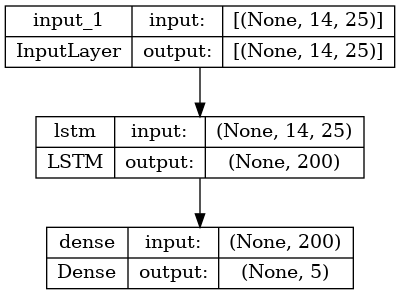

time: 486 ms (started: 2024-11-25 14:42:41 +00:00)


In [20]:
# import tensorflow_addons as tfa

# Cyclical learning rate
# steps_per_epoch = len(train_X) // batch_size
# n = 2
# cycle = 12
# epochs = cycle * n * 2
# print(epochs)

# clr = tfa.optimizers.TriangularCyclicalLearningRate(
#     initial_learning_rate=1e-4,
#     maximal_learning_rate=1e-2,
#     step_size = n * steps_per_epoch)

tf.keras.backend.clear_session()
def build_generator(n_steps_in, n_features, n_steps_out):    
    inputs = Input(shape=(n_steps_in, n_features))
    lstm = LSTM(200, activation='relu')(inputs)
    outputs = Dense(n_steps_out)(lstm)
    model = Model(inputs, outputs, name='generator')
    model.summary()
    
    return model

generator = build_generator(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True, to_file='generator.png')

/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 25)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 3, 32)             2432      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 3, 32)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 batch_normalization_6 (Bat  (None, 2, 64)             256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 2, 64)             0         
                                                            

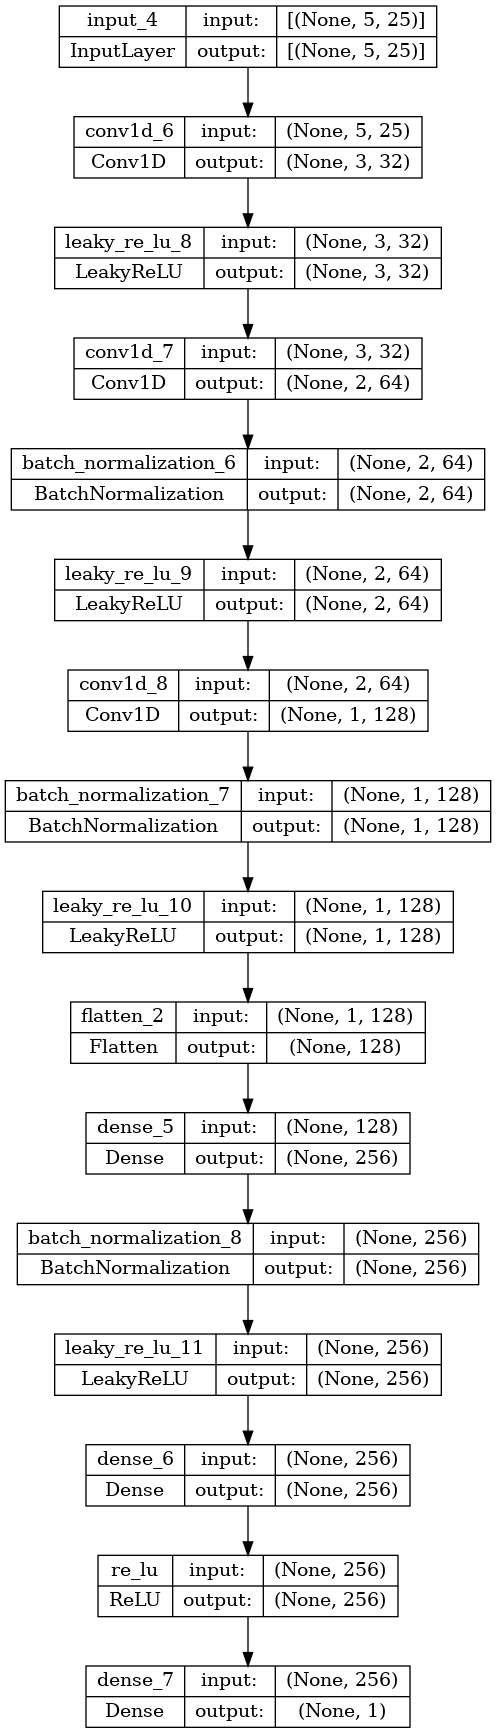

time: 549 ms (started: 2024-11-25 14:51:44 +00:00)


In [24]:
from keras import backend 
from keras.constraints import Constraint

def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

#critic model
def build_critic(n_steps_out, n_features):
    initializer = tf.keras.initializers.RandomNormal(0., 0.02)
    const = ClipConstraint(0.01)
    
    inputs = Input(shape=(n_steps_out, n_features))
    
    # Use Conv1D or more layers for improved feature extraction
    x = Conv1D(32, kernel_size=3, strides=2, padding='same', 
               kernel_constraint=const, 
               kernel_initializer=initializer)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(64, kernel_size=3, strides=2, padding='same', 
               kernel_constraint=const, 
               kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(128, kernel_size=3, strides=2, padding='same', 
               kernel_constraint=const, 
               kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Dense(256)(x)
    x = ReLU()(x)
    
    # Single output neuron for Wasserstein critic
    outputs = Dense(1)(x)
    
    model = tf.keras.models.Model(inputs, outputs, name='critic')
    
    
    model.summary()
    return model

critic = build_critic(n_steps_out=n_steps_out, n_features=train_X.shape[2])
tf.keras.utils.plot_model(critic, show_shapes=True, show_layer_names=True, to_file='discriminator.png')

In [25]:
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	model.add(generator)
	model.add(critic)

	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

time: 1.32 ms (started: 2024-11-25 14:53:54 +00:00)


In [10]:
def build_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(n_steps_out,train_X.shape[2]))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='mae')
    return gan

time: 939 µs (started: 2024-11-25 12:49:30 +00:00)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping],
)

model.save('./model/lstm_model.keras')

Epoch 1/200
1034/1034 - 24s - loss: 0.0358 - val_loss: 0.0195 - 24s/epoch - 23ms/step
Epoch 2/200
1034/1034 - 22s - loss: 0.0076 - val_loss: 0.0160 - 22s/epoch - 21ms/step
Epoch 3/200
1034/1034 - 21s - loss: 0.0059 - val_loss: 0.0148 - 21s/epoch - 21ms/step
Epoch 4/200
1034/1034 - 21s - loss: 0.0054 - val_loss: 0.0140 - 21s/epoch - 20ms/step
Epoch 5/200
1034/1034 - 20s - loss: 0.0051 - val_loss: 0.0135 - 20s/epoch - 20ms/step
Epoch 6/200
1034/1034 - 21s - loss: 0.0049 - val_loss: 0.0128 - 21s/epoch - 20ms/step
Epoch 7/200
1034/1034 - 21s - loss: 0.0048 - val_loss: 0.0123 - 21s/epoch - 20ms/step
Epoch 8/200
1034/1034 - 22s - loss: 0.0047 - val_loss: 0.0118 - 22s/epoch - 21ms/step
Epoch 9/200
1034/1034 - 20s - loss: 0.0045 - val_loss: 0.0114 - 20s/epoch - 20ms/step
Epoch 10/200
1034/1034 - 20s - loss: 0.0044 - val_loss: 0.0110 - 20s/epoch - 20ms/step
Epoch 11/200
1034/1034 - 22s - loss: 0.0044 - val_loss: 0.0110 - 22s/epoch - 21ms/step
Epoch 12/200
1034/1034 - 23s - loss: 0.0043 - val_lo

In [ ]:
model = tf.keras.models.load_model('./model/lstm_model.keras')

In [ ]:
print(f"min val loss:", min(history.history['val_loss']) )
# Make predictions
y_pred = model.predict(val_X)
print(y_pred.shape)
# Evaluate for each time step
for i in range(n_steps_out):
    mae = mean_absolute_error(val_y[:, i], y_pred[:, i])
    print(f"MAE for step {i+1}: {mae: .4f}")

In [ ]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

In [ ]:
# Plotting
fig1, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
plt.grid(True, alpha=0.3)
ax1.set_title('MAE Loss During Training')

# RMSE plot (shared x-axis, different y-axis)
# ax2 = ax1.twinx()
# fig2, ax2 = plt.subplots(figsize=(10, 5))
# ax2.plot(epoch_range, history.history["unscaled_mse"], label='Train MSE', color='green')
# ax2.plot(epoch_range, history.history["val_unscaled_mse"], label='Validation MSE', color='red')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper left')
# plt.grid(True, alpha=0.3)
# ax2.set_title('RMSE During Training')

plt.tight_layout()
plt.show()

In [ ]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK', 'GS']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)